In [1]:
import os
import yaml
import argparse
import numpy as np
import pandas as pd

from pycytominer.cyto_utils import infer_cp_features

from cytominer_eval import evaluate
from cytominer_eval.transform import metric_melt
from cytominer_eval.operations.util import assign_replicates

from scripts.viz_utils import plot_replicate_correlation, plot_replicate_density

In [2]:
config = "audit_config.yaml"
profile_dir = "../0.generate-profiles/profiles"
output_dir = "results"
figure_dir = "figures"

In [3]:
np.random.seed(1234)
output_file_extensions = [".png"]

In [4]:
audit_config = {}
stream = open(config, "r")
for data in yaml.load_all(stream, Loader=yaml.FullLoader):
    batch = data["batch"]
    audit_level = data["auditlevel"]
    plates = [str(x) for x in data["plates"]]
    audit_config[batch] = {}
    audit_config[batch]["plates"] = plates
    audit_config[batch]["auditcols"] = data["auditcols"]
    audit_config[batch]["process"] = data["process"]
    audit_config[batch]["plate_files"] = {
        x: os.path.join(profile_dir, batch, x, "{}_{}.csv.gz".format(x, audit_level))
        for x in plates
    }

In [5]:
for batch in audit_config:
    batch_dict = audit_config[batch]
    process = batch_dict["process"]
    if not process:
        continue
    audit_cols = batch_dict["auditcols"]
    plate_files = batch_dict["plate_files"]
    plates = batch_dict["plates"]
    for plate in plates:
        print("Now auditing... Batch: {}; Plate: {}".format(batch, plate))
        audit_output_dir = os.path.join(output_dir, batch, plate)
        os.makedirs(audit_output_dir, exist_ok=True)

        figure_output_dir = os.path.join(figure_dir, batch, plate)
        os.makedirs(figure_output_dir, exist_ok=True)

        audit_output_file = os.path.join(audit_output_dir, "{}_audit.csv".format(plate))
        df = pd.read_csv(plate_files[plate])
        
        # Determine feature class
        features = infer_cp_features(df)
        meta_features = infer_cp_features(df, metadata=True)
        
        # Calculate and process pairwise similarity matrix
        audit_df = metric_melt(
            df=df,
            features=features,
            metadata_features=meta_features,
            similarity_metric="pearson",
            eval_metric="percent_strong"
        )

        audit_df = assign_replicates(
            similarity_melted_df=audit_df, replicate_groups=audit_cols
        )
        # What is 95% of the non replicate null distribution
        cutoff = audit_df.query("not group_replicate").similarity_metric.quantile(0.95)

        # Calculate a single number for percent strong
        percent_strong = evaluate(
            profiles=df,
            features=features,
            meta_features=meta_features,
            replicate_groups=audit_cols,
            operation="percent_strong",
            similarity_metric="pearson",
            percent_strong_quantile=0.95
        )
        
        grid_string = "~{}".format("+".join([f"{x}_pair_a" for x in audit_cols]))
        
        # Visualize the audit - output two plots for each plate
        output_base = os.path.join(
            figure_output_dir, "{}_{}_replicate_correlation".format(batch, plate)
        )
        _ = plot_replicate_correlation(
            df=audit_df,
            batch=batch,
            plate=plate,
            facet_string=grid_string,
            dpi=500,
            split_samples=True,
            output_file_base=output_base,
            output_file_extensions=output_file_extensions,
        )

        output_base = os.path.join(
            figure_output_dir, "{}_{}_density".format(batch, plate)
        )
        _ = plot_replicate_density(
            df=audit_df,
            batch=batch,
            plate=plate,
            cutoff=cutoff,
            percent_strong=percent_strong,
            dpi=500,
            output_file_base=output_base,
            output_file_extensions=output_file_extensions,
        )

Now auditing... Batch: 2020_07_02_Batch8; Plate: 218360
Now auditing... Batch: 2020_07_02_Batch8; Plate: 218361
Now auditing... Batch: 2020_07_02_Batch8; Plate: 218362
Now auditing... Batch: 2020_07_02_Batch8; Plate: 218363


In [6]:
similarity_melted_df = metric_melt(
    df=df,
    features=features,
    metadata_features=meta_features,
    similarity_metric="pearson",
    eval_metric="percent_strong"
)

similarity_melted_df = assign_replicates(
    similarity_melted_df=similarity_melted_df, replicate_groups=audit_cols
)

print(similarity_melted_df.shape)
similarity_melted_df.head()

(1770, 24)


,Metadata_plate_map_name_pair_a,Metadata_clone_number_pair_a,Metadata_plate_ID_pair_a,Metadata_plate_filename_pair_a,Metadata_treatment_pair_a,Metadata_treatment_time_pair_a,Metadata_cell_density_pair_a,Metadata_Plate_pair_a,Metadata_Well_pair_a,Metadata_plate_map_name_pair_b,...,Metadata_treatment_time_pair_b,Metadata_cell_density_pair_b,Metadata_Plate_pair_b,Metadata_Well_pair_b,pair_a_index,pair_b_index,similarity_metric,Metadata_clone_number_replicate,Metadata_treatment_replicate,group_replicate
0,218363,WT parental,218363,20200629-20200626-WTpAE-Lo,0.1% DMSO,13 hr,5x10^3 cells/well,218363,B02,218363,...,13 hr,5x10^3 cells/well,218363,B03,0,1,0.625179,True,False,False
1,218363,WT parental,218363,20200629-20200626-WTpAE-Lo,0.1% DMSO,13 hr,5x10^3 cells/well,218363,B02,218363,...,13 hr,5x10^3 cells/well,218363,B04,0,2,0.179587,True,False,False
2,218363,WT parental,218363,20200629-20200626-WTpAE-Lo,0.1% DMSO,13 hr,5x10^3 cells/well,218363,B02,218363,...,13 hr,5x10^3 cells/well,218363,B05,0,3,-0.109493,True,False,False
3,218363,WT parental,218363,20200629-20200626-WTpAE-Lo,0.1% DMSO,13 hr,5x10^3 cells/well,218363,B02,218363,...,13 hr,5x10^3 cells/well,218363,B06,0,4,0.779332,True,True,True
4,218363,WT parental,218363,20200629-20200626-WTpAE-Lo,0.1% DMSO,13 hr,5x10^3 cells/well,218363,B02,218363,...,13 hr,5x10^3 cells/well,218363,B07,0,5,0.003693,True,False,False


In [7]:
grid_string = "~{}".format("+".join([f"{x}_pair_a" for x in audit_cols]))
grid_string

'~Metadata_clone_number_pair_a+Metadata_treatment_pair_a'

In [9]:
import plotnine as gg

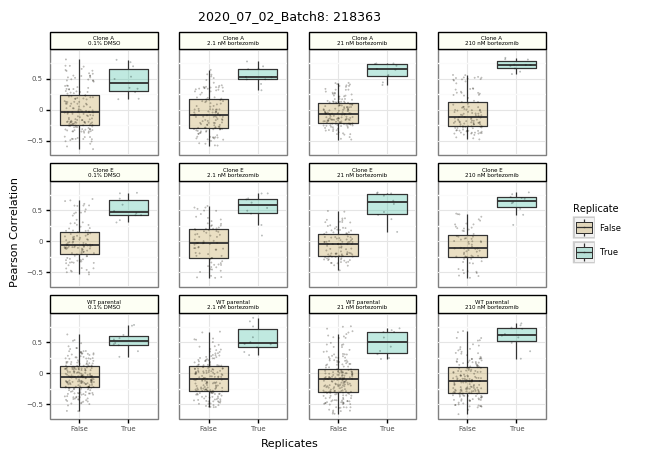

<ggplot: (8794605926478)>

In [10]:
(
    gg.ggplot(
        similarity_melted_df,
        gg.aes(x="group_replicate", y="similarity_metric", fill="group_replicate"),
    )
    + gg.geom_boxplot(
        alpha=0.3, outlier_alpha=0, width=0.8, notchwidth=0.25, fatten=1.5
    )
    + gg.geom_jitter(shape=".", size=0.001, alpha=0.3, width=0.3, height=0)
    + gg.scale_fill_manual(
        name="Replicate",
        labels={"True": "True", "False": "False"},
        values=["#B99638", "#2DB898"],
    )
    + gg.xlab("Replicates")
    + gg.ylab("Pearson Correlation")
    + gg.ggtitle("{}: {}".format(batch, plate))
    + gg.theme_bw()
    + gg.theme(
        subplots_adjust={"wspace": 0.2},
        title=gg.element_text(size=9),
        axis_text=gg.element_text(size=5),
        axis_title=gg.element_text(size=8),
        legend_text=gg.element_text(size=6),
        legend_title=gg.element_text(size=7),
        strip_text=gg.element_text(size=4, color="black"),
        strip_background=gg.element_rect(colour="black", fill="#fdfff4"),
    )
) + gg.facet_wrap(grid_string)

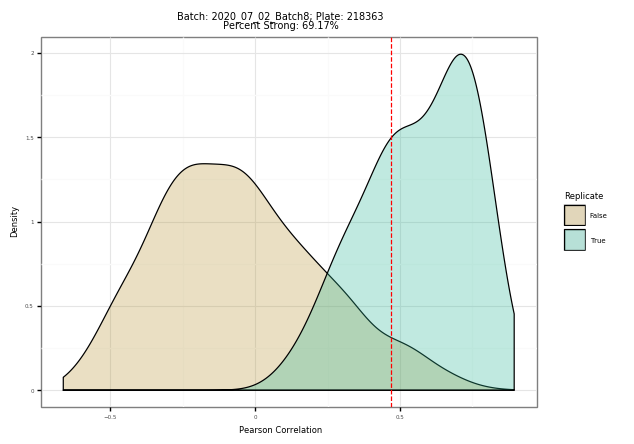

<ggplot: (-9223363242819222384)>

In [34]:
(
    gg.ggplot(similarity_melted_df, gg.aes(x="similarity_metric", fill="group_replicate"))
    + gg.geom_density(alpha=0.3)
    + gg.scale_fill_manual(
        name="Replicate",
        labels={"True": "True", "False": "False"},
        values=["#B99638", "#2DB898"],
    )
    + gg.geom_vline(xintercept=cutoff, color="red", linetype="dashed")
    + gg.xlab("Pearson Correlation")
    + gg.ylab("Density")
    + gg.ggtitle(f"Batch: {batch}; Plate: {plate}\nPercent Strong: {np.round(percent_strong_profiles * 100, 2)}%")
    + gg.theme_bw()
    + gg.theme(
        title=gg.element_text(size=7),
        axis_text=gg.element_text(size=4),
        axis_title=gg.element_text(size=6),
        legend_text=gg.element_text(size=5),
        legend_title=gg.element_text(size=6),
        strip_text=gg.element_text(size=4, color="black"),
        strip_background=gg.element_rect(colour="black", fill="#fdfff4"),
    )
)